In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
main_path = Path('..').resolve()
sys.path.append(str(main_path))

from src.dataset import MetaStockDataset
from src.utils import ARGProcessor

In [2]:
import torch

torch.__version__

'1.11.0+cu113'

In [3]:
setting_file = Path('.') / 'kdd.yml'

meta_args = ARGProcessor(setting_file=setting_file)
data_kwargs = meta_args.get_args(cls=MetaStockDataset)

meta_train = MetaStockDataset(meta_type='train', **data_kwargs)
# meta_test1 = MetaStockDataset(meta_type='test1', **data_kwargs)
# meta_test2 = MetaStockDataset(meta_type='test2', **data_kwargs)
# meta_test3 = MetaStockDataset(meta_type='test3', **data_kwargs)

Processing data and candidates for train: 100%|██████████| 40/40 [00:00<00:00, 42.40it/s]


In [6]:
all_data = meta_train.generate_tasks()
all_data

StockDataDict(T=5, numpy)
- query: (5, 1, 5, 11)
- query_labels: (5,)
- support: (5, 4, 5, 11)
- support_labels: (20,)

In [13]:
all_data.to('cpu')
all_data

StockDataDict(T=5, tensor.cpu)
- query: torch.Size([5, 1, 5, 11])
- query_labels: torch.Size([5])
- support: torch.Size([5, 4, 5, 11])
- support_labels: torch.Size([20])

In [14]:
dict(all_data.items())

{'query': tensor([[[[ 1.1500e+00,  1.9658e+00, -4.0116e-02,  1.7414e-01,  1.7414e-01,
             7.2213e-02,  8.1185e-01,  3.7544e-01,  1.5056e-02, -1.7809e-02,
             1.3523e-01],
           [-1.3814e+00,  2.2365e-01, -1.4472e+00,  1.6448e+00,  1.6448e+00,
            -1.2235e+00, -7.9228e-01, -1.0826e+00, -1.4591e+00, -1.6588e+00,
            -1.3820e+00],
           [ 5.2169e-02,  4.8264e-01, -2.3480e-01,  8.5515e-01,  8.5515e-01,
            -1.6097e+00, -1.6694e+00, -1.6376e+00, -2.1758e+00, -2.3469e+00,
            -2.2012e+00],
           [ 2.3990e+00,  2.4923e+00,  0.0000e+00, -2.1263e+00, -2.1263e+00,
             5.2779e-01,  3.2797e-01,  5.5593e-01, -1.8730e-02, -2.1202e-01,
            -1.4622e-01],
           [-2.9082e-01,  3.4369e-01, -6.7416e-01,  8.2634e-01,  8.2634e-01,
            -3.1725e-02, -4.5935e-01, -1.8712e-01, -6.9787e-01, -9.7228e-01,
            -9.2186e-01]]],
 
 
         [[[-1.6693e-01,  1.9477e+00, -1.5581e+00,  1.6403e+00,  1.6403e+00,
        

In [7]:
for i, data in enumerate(stock_data):
    break

In [19]:
q_inputs.shape


torch.Size([5, 1, 5, 11])

In [8]:
# inputs for all stocks
q_inputs = data['query']
q_labels = data['query_labels']
s_inputs = data['support']
s_labels = data['support_labels']

---

## Data generator

In [20]:
window_size = 10
symbol = 'NVS'
df_stock = meta_train.data[symbol]
# filter out unpossible candidates
labels_indices = meta_train.candidates[symbol] 
labels_indices = labels_indices[labels_indices >= window_size]

for i in range(len(labels_indices)):
    array = df_stock.loc[labels_indices, 'label'].loc[:(labels_indices[i])].to_numpy()
    if meta_train.check_condition(array):
        break

# satisfied condition label index | smallest support index | smallest query index
candidates = labels_indices[(i+1):]

In [5]:
labels_indices, candidates

(array([  10,   12,   13, ..., 1980, 1983, 1984]),
 array([  21,   22,   24, ..., 1980, 1983, 1984]))

In [6]:
df_stock.loc[labels_indices].iloc[:10, -1:]

,label
10,0
12,0
13,1
14,0
16,0
18,0
19,1
21,1
22,0
24,1


In [16]:
data = dict(
    query = None,
    query_labels = None,
    support = None,
    support_labels = None,
)

q_target = np.random.choice(candidates)   # index in the dataframe
# for q_target in y_q:
    # Queries
q_idx = np.arange(len(labels_indices))[labels_indices == q_target][0]  # get the index of label data
q_end = np.array([q_target]) 
q_start = q_end - window_size
q_data, q_labels = meta_train.generate_data(df_stock, y_start=q_start, y_end=q_end)

data['query'] = q_data
data['query_labels'] = q_labels[0]  # (1,)

# for checking
s_idx = q_idx - 1
s_target = labels_indices[s_idx]
# ----------

# Supports
s_fall, s_rise = meta_train.get_rise_fall(df_stock, labels_indices, idx=q_idx, n_select=meta_train.n_support)
s_end = np.concatenate([s_fall, s_rise])
s_start = s_end - window_size
s_data, s_labels = meta_train.generate_data(df_stock, y_start=s_start, y_end=s_end)

data['support'] = s_data
data['support_labels'] = s_labels  # (N*K,)


print()   
print(f'query index: {q_idx}({q_target}) = {df_stock.loc[q_target, "label"]}')
print(f'- start={q_start} end={q_end}')
print(f'support index: {s_idx}({s_target}) = {df_stock.loc[s_target, "label"]}')
print(f'- start={s_start} end={s_end}')


query index: 329(519) = 0
- start=[509] end=[519]
support index: 328(518) = 1
- start=[505 504 508 506] end=[515 514 518 516]


In [17]:
data

{'query': array([[[ 3.04606233,  3.29370472, -0.29718424, -1.15054351,
          -1.15054428,  2.04556454,  3.63545954,  3.64371445,
           4.58518663,  6.45962932,  8.34983912],
         [-1.67309404,  0.36037067, -2.70270027, -3.78901179,
           0.49146141,  0.94936478,  2.6797269 ,  3.08236662,
           3.38965346,  5.27246423,  7.19715659],
         [ 0.37145928,  1.14088621, -0.90209872, -2.98584057,
          -2.98584282,  2.76937358,  5.12026063,  5.71760788,
           5.82449541,  7.7958169 ,  9.7620181 ],
         [ 3.60781593,  4.13109325, -0.33049297, -3.66144345,
          -3.66144229,  4.99585197,  8.01737191,  9.04212402,
           9.18271734, 11.06111948, 13.07892477],
         [ 0.85517517,  1.24138207, -0.19310345, -0.16524648,
          -0.16524716,  3.59172329,  6.83144046,  8.51352107,
           8.91481482, 10.44656889, 12.45991762],
         [ 2.25367806,  2.802661  , -0.3467177 , -4.52413517,
          -4.52413654,  6.16006736, 10.07340899, 12.5618172

In [16]:
np.random.seed(999)

data = dict(
    query = [],
    query_labels = [],
    # query_masks = [],
    support = [],
    support_labels = [],
    # support_masks = []
)

y_q = np.random.choice(candidates, size=(meta_train.n_sample,), replace=False)   # index in the dataframe
y_q = np.concatenate([[candidates[0]], y_q[:-1]])
for q_target in y_q:
    # Queries
    q_idx = np.arange(len(labels_indices))[labels_indices == q_target][0]  # get the index of label data
    q_end = np.array([q_target]) 
    q_start = q_end - window_size
    q_data, q_labels = meta_train.generate_data(df_stock, y_start=q_start, y_end=q_end)

    data['query'].append(q_data)
    data['query_labels'].append(q_labels)

    # Supports
    s_idx = q_idx - 1
    s_target = labels_indices[s_idx]

    s_fall, s_rise = meta_train.get_rise_fall(df_stock, labels_indices, idx=q_idx, n_select=meta_train.n_support)
    s_end = np.concatenate([s_fall, s_rise])
    s_start = s_end - window_size
    s_data, s_labels = meta_train.generate_data(df_stock, y_start=s_start, y_end=s_end)
    
    data['support'].append(s_data)
    data['support_labels'].append(s_labels)
    
    print()   
    print(f'query index: {q_idx}({q_target}) = {df_stock.loc[q_target, "label"]}')
    print(f'- start={q_start} end={q_end}')
    print(f'support index: {s_idx}({s_target}) = {df_stock.loc[s_target, "label"]}')
    print(f'- start={s_start} end={s_end}')
    break
for k, v in data.items():
    data[k] = np.array(v)


query index: 7(21) = 1
- start=[11] end=[21]
support index: 6(19) = 1
- start=[8 6 9 3] end=[18 16 19 13]


In [17]:
data['support_labels']

array([[0, 0, 1, 1]], dtype=uint8)

---

# Modeling

In [14]:
import torch
import torch.nn as nn
from src.model import MetaModel

model_kwargs = meta_args.get_args(cls=MetaModel)
model = MetaModel(**model_kwargs)

rt_attn = True

## Forward

### forward_encoder

In [15]:
# encode_lstm
l, attn = model.encode_lstm(s_inputs, rt_attn=rt_attn)  # lstm_encoded: (B, N*K, E)
print(f'`l` Outputs: {l.size()}, {attn.size()}')
print(l[0])

`l` Outputs: torch.Size([5, 4, 5]), torch.Size([5, 4, 5])
tensor([[-1.0755,  0.8342, -1.3201,  1.0824,  0.4789],
        [-0.7977,  1.1047, -1.5387,  0.5298,  0.7018],
        [-1.2502,  0.8341, -1.1349,  1.1266,  0.4245],
        [-0.9094,  0.9294, -1.4812,  0.8805,  0.5806]],
       grad_fn=<SelectBackward0>)


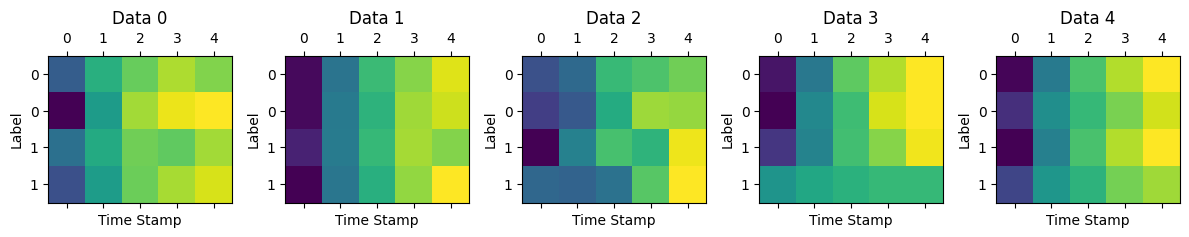

In [16]:
import matplotlib.pyplot as plt

if isinstance(attn, torch.Tensor):
    attn_numpy = attn.detach().numpy()
else:
    attn_numpy = attn
masks = [0, 0, 1, 1]

B = attn_numpy.shape[0]
fig, axes = plt.subplots(1, B, figsize=(12, 10))
for i in range(B):
    ax = axes[i]
    ax.matshow(attn_numpy[i])
    ax.set_title(f'Data {i}')

for ax in axes:
    ax.set_yticks(np.arange(len(masks)))
    ax.set_yticklabels(masks)
    ax.set_ylabel('Label')
    ax.set_xlabel('Time Stamp')
plt.tight_layout()
plt.show()

In [17]:
# encode_linear
# Reshape the size
B = l.size(0)
N = model.output_size
K = l.size(1) // N
if rt_attn:
    attn = attn.view(B, N, K, -1)  # attn: (B, N, K, T)
l_reshape = l.view(B, N, K, -1)  # l_reshape: (B, N, K, E)
e = model.encoder(l_reshape)  # e: (B, N, K, H)
print(f'`encoded` Outputs: {e.size()}')
print(e[0])

`encoded` Outputs: torch.Size([5, 2, 2, 3])
tensor([[[-0.0325,  0.4787, -0.6320],
         [ 0.3437,  0.2997, -0.4771]],

        [[-0.1893,  0.5647, -0.6558],
         [ 0.1624,  0.3811, -0.5737]]], grad_fn=<SelectBackward0>)


Relation Net: class-conditional multivariate Gaussian distribution with a diagonal covariance

The paper concatenate tensors for relation net inputs.

Let $R(x_{i}^{p}, x_{j}^{q})$ to represent the inputs of hidden state on concatenated relations between classes, $i, j$ for shot index, $p, q$ for class index.

The tensor shape is $(B, N^2, K^2, 2H)$. For each data(row) in $B$, the data relationship is $\sum_{i, j}^N \sum_{p, q}^{K} R(x_{i}^{p}, x_{j}^{q})$

e.g.,  N way K shot = 2 way 2 shot

| Relation | Left | Right |
|---|---|---|
| $R(x_0^0, x_0^0)$ | $h_{K_0}^{N_0}$ | $h_{K_0}^{N_0}$ |
| $R(x_0^0, x_1^0)$ | $h_{K_0}^{N_0}$ | $h_{K_1}^{N_0}$ | 
| $R(x_1^0, x_1^0)$ | $h_{K_1}^{N_0}$ | $h_{K_0}^{N_0}$ |
| $R(x_1^0, x_0^0)$ | $h_{K_1}^{N_0}$ | $h_{K_1}^{N_0}$ | 
| | | |
| $R(x_0^0, x_0^1)$ | $h_{K_0}^{N_0}$ | $h_{K_0}^{N_1}$ |
| $R(x_0^0, x_1^1)$ | $h_{K_0}^{N_0}$ | $h_{K_1}^{N_1}$ | 
| $R(x_1^0, x_1^1)$ | $h_{K_1}^{N_0}$ | $h_{K_0}^{N_1}$ |
| $R(x_1^0, x_0^1)$ | $h_{K_1}^{N_0}$ | $h_{K_1}^{N_1}$ | 
| | | |
| $R(x_0^1, x_0^0)$ | $h_{K_0}^{N_1}$ | $h_{K_0}^{N_0}$ |
| $R(x_0^1, x_1^0)$ | $h_{K_0}^{N_1}$ | $h_{K_1}^{N_0}$ | 
| $R(x_1^1, x_1^0)$ | $h_{K_1}^{N_1}$ | $h_{K_0}^{N_0}$ |
| $R(x_1^1, x_0^0)$ | $h_{K_1}^{N_1}$ | $h_{K_1}^{N_0}$ | 
| | | |
| $R(x_0^1, x_0^1)$ | $h_{K_0}^{N_1}$ | $h_{K_0}^{N_1}$ |
| $R(x_0^1, x_1^1)$ | $h_{K_0}^{N_1}$ | $h_{K_1}^{N_1}$ | 
| $R(x_1^1, x_1^1)$ | $h_{K_1}^{N_1}$ | $h_{K_0}^{N_1}$ |
| $R(x_1^1, x_0^1)$ | $h_{K_1}^{N_1}$ | $h_{K_1}^{N_1}$ | 

In [18]:
# e.g.
a = torch.randn(1, 2, 2, 3)
left = torch.repeat_interleave(a, 2, dim=2)
left = torch.repeat_interleave(left, 2, dim=1)
right = a.repeat((1, 2, 2, 1))
temp = torch.cat([left, right], dim=-1)
temp

tensor([[[[-0.0247, -0.8072, -1.6896, -0.0247, -0.8072, -1.6896],
          [-0.0247, -0.8072, -1.6896,  0.8147,  0.1862,  1.3567],
          [ 0.8147,  0.1862,  1.3567, -0.0247, -0.8072, -1.6896],
          [ 0.8147,  0.1862,  1.3567,  0.8147,  0.1862,  1.3567]],

         [[-0.0247, -0.8072, -1.6896,  0.9556, -0.5343, -1.0513],
          [-0.0247, -0.8072, -1.6896, -1.8305,  0.2426,  0.4125],
          [ 0.8147,  0.1862,  1.3567,  0.9556, -0.5343, -1.0513],
          [ 0.8147,  0.1862,  1.3567, -1.8305,  0.2426,  0.4125]],

         [[ 0.9556, -0.5343, -1.0513, -0.0247, -0.8072, -1.6896],
          [ 0.9556, -0.5343, -1.0513,  0.8147,  0.1862,  1.3567],
          [-1.8305,  0.2426,  0.4125, -0.0247, -0.8072, -1.6896],
          [-1.8305,  0.2426,  0.4125,  0.8147,  0.1862,  1.3567]],

         [[ 0.9556, -0.5343, -1.0513,  0.9556, -0.5343, -1.0513],
          [ 0.9556, -0.5343, -1.0513, -1.8305,  0.2426,  0.4125],
          [-1.8305,  0.2426,  0.4125,  0.9556, -0.5343, -1.0513],
    

after relation network, average the values for each class for all shots($K$)

e.g.,  N way K shot = 2 way 2 shot

| Class | Relation |
|---|---|
| 0 | $f\big( R(x_0^0, x_0^0) \big)$ |
| 0 | $f\big( R(x_0^0, x_1^0) \big)$ |
| 0 | $f\big( R(x_1^0, x_1^0) \big)$ |
| 0 | $f\big( R(x_1^0, x_0^0) \big)$ | 
| 0 | $f\big( R(x_0^0, x_0^1) \big)$ |
| 0 | $f\big( R(x_0^0, x_1^1) \big)$ |
| 0 | $f\big( R(x_1^0, x_1^1) \big)$ |
| 0 | $f\big( R(x_1^0, x_0^1) \big)$ |
|   | |
| 1 | $f\big( R(x_0^1, x_0^0) \big)$ | 
| 1 | $f\big( R(x_0^1, x_1^0) \big)$ | 
| 1 | $f\big( R(x_1^1, x_1^0) \big)$ | 
| 1 | $f\big( R(x_1^1, x_0^0) \big)$ |
| 1 | $f\big( R(x_0^1, x_0^1) \big)$ |
| 1 | $f\big( R(x_0^1, x_1^1) \big)$ |
| 1 | $f\big( R(x_1^1, x_1^1) \big)$ |
| 1 | $f\big( R(x_1^1, x_0^1) \big)$ |

In [19]:
# e.g., if relation net is identity function, the output is
temp.view(1, 2, 2*2*2, 6)

tensor([[[[-0.0247, -0.8072, -1.6896, -0.0247, -0.8072, -1.6896],
          [-0.0247, -0.8072, -1.6896,  0.8147,  0.1862,  1.3567],
          [ 0.8147,  0.1862,  1.3567, -0.0247, -0.8072, -1.6896],
          [ 0.8147,  0.1862,  1.3567,  0.8147,  0.1862,  1.3567],
          [-0.0247, -0.8072, -1.6896,  0.9556, -0.5343, -1.0513],
          [-0.0247, -0.8072, -1.6896, -1.8305,  0.2426,  0.4125],
          [ 0.8147,  0.1862,  1.3567,  0.9556, -0.5343, -1.0513],
          [ 0.8147,  0.1862,  1.3567, -1.8305,  0.2426,  0.4125]],

         [[ 0.9556, -0.5343, -1.0513, -0.0247, -0.8072, -1.6896],
          [ 0.9556, -0.5343, -1.0513,  0.8147,  0.1862,  1.3567],
          [-1.8305,  0.2426,  0.4125, -0.0247, -0.8072, -1.6896],
          [-1.8305,  0.2426,  0.4125,  0.8147,  0.1862,  1.3567],
          [ 0.9556, -0.5343, -1.0513,  0.9556, -0.5343, -1.0513],
          [ 0.9556, -0.5343, -1.0513, -1.8305,  0.2426,  0.4125],
          [-1.8305,  0.2426,  0.4125,  0.9556, -0.5343, -1.0513],
        

In [20]:
# relation_net
hs = model.relation_net(e)  # hs: (B, N, 2H)
print(f'`hs` Outputs: {hs.size()}')
print(hs[0])

`hs` Outputs: torch.Size([5, 2, 6])
tensor([[0.0000, 0.0000, 0.0072, 0.0006, 0.0313, 0.0201],
        [0.0000, 0.0000, 0.0110, 0.0000, 0.0478, 0.0383]],
       grad_fn=<SelectBackward0>)


In [21]:
# sample: parameters of a probability distribution in a low-dimensional space z for each class
z, kld_loss = model.sample(hs, size=model.hidden_size)  # z: (B, N, H)
x = l.mean(1)  # x: (B, E)
print(f'`z` Outputs: {z.size()}')
print(z[0])
print()
print(f'`x` Outputs: {x.size()}')
print(x[0])

`z` Outputs: torch.Size([5, 2, 3])
tensor([[-0.2002, -0.4402,  0.8758],
        [ 0.7040, -1.4166,  0.9400]], grad_fn=<SelectBackward0>)

`x` Outputs: torch.Size([5, 5])
tensor([-1.0082,  0.9256, -1.3687,  0.9048,  0.5465],
       grad_fn=<SelectBackward0>)


### forward_decoder

In [22]:
# decode
parameters = model.decode(z)
print(f'`parameters` Outputs: {parameters.size()}')
print(parameters[0])

`parameters` Outputs: torch.Size([5, 2, 5])
tensor([[ 0.2528, -0.6938, -1.6654,  1.0655,  0.8195],
        [-0.6311,  1.3353,  2.9934, -1.1317, -0.5474]],
       grad_fn=<SelectBackward0>)


In [26]:
# predict
loss, score = model.predict(x, parameters, s_labels)
print(f'Loss = {loss:.4f}\nScores =\n{score}')

Loss = 3.7132
Scores =
tensor([[ 2.7942, -3.5480],
        [ 3.0059, -6.2314],
        [ 1.1042,  0.1904],
        [-4.7380, -2.4826],
        [-1.9945, -3.0739]], grad_fn=<SqueezeBackward1>)


In [30]:
total_loss, q_scores, s_attn, q_attn = model(
    data=data,
    rt_attn=True
)

In [31]:
total_loss

tensor(2.7112, grad_fn=<AddBackward0>)

In [15]:
s_l, s_z, kld_loss, s_attn = model.forward_encoder(s_inputs, rt_attn=rt_attn)

# initialize z', Forward Decoder
z_prime = s_z
s_loss, s_scores, parameters = model.forward_decoder(z=z_prime, l=s_l, labels=s_labels)
# inner adaptation to z
for i in range(5):
    z_prime.retain_grad()
    s_loss.backward(retain_graph=True)
    z_prime = z_prime - model.inner_lr * z_prime.grad.data
    s_loss, s_scores, parameters = model.forward_decoder(z=z_prime, l=s_l, labels=s_labels)

# Stop Gradient: 
# z_prime.requires_grad == False
# s_z.requires_grad == True
z_prime = z_prime.detach()  
z_loss = torch.mean((z_prime - s_z)**2)


In [22]:
model.loss_fn(s_scores, s_labels.view(-1))

tensor(-0.1696, grad_fn=<NllLossBackward0>)

In [21]:
model.recorder.update('Support_Accuracy', s_scores, s_labels.view(-1))

# Metrics

In [94]:
from collections import defaultdict
import torchmetrics as tm
from typing import Dict, Tuple, List

class MetricRecorder():
    def __init__(self):
        cs = tm.MetricCollection({
            'Accuracy': tm.Accuracy(), 
            'Loss': tm.SumMetric()
        })
        self.metrics = tm.MetricCollection([
            cs.clone('Support_'), cs.clone('Query_'), cs.clone('Finetune_'),
            tm.MetricCollection({
                'Inner': tm.MeanMetric(), 'Finetuning': tm.MeanMetric()
            }, postfix='_LR'),
            tm.MetricCollection({
                'Total': tm.SumMetric(), 
                'KLD': tm.SumMetric(), 
                'Z': tm.SumMetric(),
                'Orthogonality': tm.SumMetric()
            }, postfix='_Loss')
        ])

        self.reset_window_metrics()

    @property
    def keys(self):
        return list(self.metrics.keys())

    def reset_window_metrics(self):
        self.window_metrics = defaultdict(dict)

    def update(self, key, scores=None | torch.FloatTensor, targets=None | torch.LongTensor):
        if 'Accuracy' in key:
            if targets is None:
                raise KeyError('Must insert `targets` to calculate accuracy.')
            self.metrics[key].update(scores, targets)
        else:
            self.metrics[key].update(scores)

    def compute(self):
        results = {}
        for k in self.keys:
            m = self.metrics[k].compute()
            if isinstance(m, torch.Tensor):
                m = m.detach().numpy()
            results[k] = m
        return results

    def reset(self):
        for k in self.keys:
            self.metrics[k].reset()

    def update_window_metrics(self, window_size):
        results = self.compute()
        self.window_metrics[window_size] = results

    def get_window_metrics(self, window_size):
        return self.window_metrics[window_size]

    def compute_total_metrics(self):
        # averaged by number of window size
        windows, metrics = list(zip(*self.window_metrics.items()))
        results = {k: 0.0 for k in self.keys}
        for m in metrics:
            for k in self.keys:
                results[k] += m[k]
        for k in self.keys:
            results[k] /= len(windows)  # TODO: calculate average performance of 4 tasks?

        return results

    def get_log_data(self, prefix: str, window_size: int | None=None):
        log_string = f'{prefix}'
        if window_size is not None:
            log_string += f'-WinSize={window_size}'
            metrics = self.get_window_metrics(window_size)
        else:
            metrics = self.compute_total_metrics()

        log_data = {}
        for key in self.keys:
            value = metrics[key]
            log_data[f'{log_string}-{key}'] = value

        return log_data

    def extract_query_loss_acc(self, logs: Dict[str, float] | List[Dict[str, float]]) -> Dict[str, Tuple[float, float]]:
        to_filter = ['Query_Accuracy', 'Query_Loss']
        check_func = lambda x: sum([1 if f in x[0] else 0 for f in to_filter if f in x[0]])
        if isinstance(logs, dict):
            # cumulated logs
            filtered = dict(filter(check_func, logs.items()))
        else:
            filtered = {}
            for l in logs:
                win_filtered = dict(filter(check_func, l.items()))
                filtered.update(win_filtered)
        return filtered

In [95]:
recorder = MetricRecorder()
recorder.reset()  
print(recorder.keys)
print(recorder.window_metrics)

['Support_Accuracy', 'Support_Loss', 'Query_Accuracy', 'Query_Loss', 'Finetune_Accuracy', 'Finetune_Loss', 'Finetuning_LR', 'Inner_LR', 'KLD_Loss', 'Orthogonality_Loss', 'Total_Loss', 'Z_Loss']
defaultdict(<class 'dict'>, {})


In [99]:
all_total_loss = 0.0
model.recorder.reset_window_metrics()
for window_size, stock_data in all_data.items():
    stock_data.to('cpu')
    # Reset record: only update for a single window size with `number of stocks`
    for data in stock_data:
        total_loss, *_ = model(data=data)
        all_total_loss += total_loss
    break
    # recorder.update_window_metrics(window_size)

In [106]:
data.keys()

dict_keys(['query', 'query_labels', 'support', 'support_labels'])

In [104]:
for k in model.recorder.keys:
    print(k, model.recorder.metrics[k].compute())


Support_Accuracy tensor(0.5702)
Support_Loss tensor(1033.8970)


c:\Users\simon\.virtualenvs\SMILE-YJBuims-\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


RuntimeError: You have to have determined mode.

In [84]:
scores = torch.FloatTensor([[0.0, 0.0], [0.0, 0.0]])
targets = torch.LongTensor([0, 0])
loss = torch.FloatTensor([0.0, 0.0])
lr = 0.276

recorder.update('Support_Accuracy', scores, targets) #
recorder.update('Support_Loss', loss)#
recorder.update('Query_Accuracy', scores, targets) #
recorder.update('Query_Loss', loss) #
recorder.update('Finetune_Accuracy', scores, targets) #
recorder.update('Finetune_Loss', loss) #
recorder.update('Finetuning_LR', lr) #
recorder.update('Inner_LR', lr) #
recorder.update('KLD_Loss', loss) #
recorder.update('Orthogonality_Loss', loss)  # 
recorder.update('Total_Loss', loss) #
recorder.update('Z_Loss', loss) #

In [85]:
recorder.compute()

{'Support_Accuracy': array(1., dtype=float32),
 'Support_Loss': array(0., dtype=float32),
 'Query_Accuracy': array(1., dtype=float32),
 'Query_Loss': array(0., dtype=float32),
 'Finetune_Accuracy': array(1., dtype=float32),
 'Finetune_Loss': array(0., dtype=float32),
 'Finetuning_LR': array(0.276, dtype=float32),
 'Inner_LR': array(0.276, dtype=float32),
 'KLD_Loss': array(0., dtype=float32),
 'Orthogonality_Loss': array(0., dtype=float32),
 'Total_Loss': array(0., dtype=float32),
 'Z_Loss': array(0., dtype=float32)}

In [41]:
recorder.update_window_metrics(5)

In [42]:
scores = torch.FloatTensor([[0.4, 1.2], [3.1, 1.2]])
targets = torch.LongTensor([1, 0])
loss = torch.FloatTensor([1.7, 1.6])
lr = 0.14

recorder.update('Support_Accuracy', scores, targets) #
recorder.update('Support_Loss', loss)#
recorder.update('Query_Accuracy', scores, targets) #
recorder.update('Query_Loss', loss) #
recorder.update('Finetune_Accuracy', scores, targets) #
recorder.update('Finetune_Loss', loss) #
recorder.update('Finetuning_LR', lr) #
recorder.update('Inner_LR', lr) #
recorder.update('KLD_Loss', loss) #
recorder.update('Orthogonality_Loss', loss)  # 
recorder.update('Total_Loss', loss) #
recorder.update('Z_Loss', loss) #

In [43]:
recorder.compute()

{'Support_Accuracy': array(0.5, dtype=float32),
 'Support_Loss': array(10.4, dtype=float32),
 'Query_Accuracy': array(0.5, dtype=float32),
 'Query_Loss': array(10.4, dtype=float32),
 'Finetune_Accuracy': array(0.5, dtype=float32),
 'Finetune_Loss': array(10.4, dtype=float32),
 'Finetuning_LR': array(0.208, dtype=float32),
 'Inner_LR': array(0.208, dtype=float32),
 'KLD_Loss': array(10.4, dtype=float32),
 'Orthogonality_Loss': array(10.4, dtype=float32),
 'Total_Loss': array(10.4, dtype=float32),
 'Z_Loss': array(10.4, dtype=float32)}

In [44]:
recorder.update_window_metrics(10)

In [45]:
logs = recorder.get_log_data('Train')
logs

{'Train-Support_Accuracy': 0.25,
 'Train-Support_Loss': 10.399999618530273,
 'Train-Query_Accuracy': 0.25,
 'Train-Query_Loss': 10.399999618530273,
 'Train-Finetune_Accuracy': 0.25,
 'Train-Finetune_Loss': 10.399999618530273,
 'Train-Finetuning_LR': 0.24199999868869781,
 'Train-Inner_LR': 0.24199999868869781,
 'Train-KLD_Loss': 10.399999618530273,
 'Train-Orthogonality_Loss': 10.399999618530273,
 'Train-Total_Loss': 10.399999618530273,
 'Train-Z_Loss': 10.399999618530273}

In [47]:
recorder.extract_query_loss_acc(logs)

{'Train-Query_Accuracy': 0.25, 'Train-Query_Loss': 10.399999618530273}

---

## Universe

In [11]:
import json 
ps = list((meta_train.data_dir / 'kdd17/price_long_50').glob('*.csv'))
with (Path('../data').resolve() / 'kdd17/stock_universe.json').open('r') as file:
    universe_dict = json.load(file)

universe_key = 'known'
universe = universe_dict['0'][universe_key]
iterator = [p for p in ps if p.name.strip('.csv') in universe]

In [55]:
p = iterator[29]
stock_symbol = p.name.rstrip('.csv')
df_single = meta_train.load_single_stock(p)
df_single = df_single.loc[df_single["date"].between("2014-01-01", '2015-01-01')].reset_index(drop=True)

In [56]:
symbol = p.name.strip('.csv') # 'AMZN'
window_size = 5
n_support = 4
df_stock = meta_train.data[symbol]
labels_indices = meta_train.candidates[symbol]
labels_candidates = labels_indices[labels_indices >= window_size]
idx = meta_train.get_possible_idx(df_stock, labels_candidates)
labels_candidates = labels_candidates[idx:]

In [57]:
labels_candidates

array([  15,   16,   17, ..., 1982, 1983, 1984], dtype=int64)

In [60]:
df_stock.loc[:15, ['date', 'label']]

,date,label
0,2007-02-14,2
1,2007-02-15,0
2,2007-02-16,2
3,2007-02-20,2
4,2007-02-21,0
5,2007-02-22,2
6,2007-02-23,2
7,2007-02-26,2
8,2007-02-27,0
9,2007-02-28,1


In [61]:
y_q = np.array([labels_candidates[0]])
y_qs = y_q - window_size
query, query_labels = meta_train.generate_data(df_stock, y_start=y_qs, y_end=y_q)

In [62]:
y_qs

array([10], dtype=int64)

In [63]:
query.round(4)

array([[[-0.5848,  0.6405, -1.9772,  0.3073,  0.3073,  0.1392,  0.7574,
          0.9728,  1.0874,  0.943 ,  0.9697],
        [ 1.1299,  1.5819, -0.113 , -1.4202, -1.4202,  1.1243,  1.9407,
          2.2467,  2.4124,  2.2888,  2.3452],
        [ 0.8847,  1.0845, -0.1142, -1.017 , -1.017 ,  1.387 ,  2.5942,
          3.0403,  3.2848,  3.2297,  3.273 ],
        [-0.5072,  0.3099, -1.0989,  1.2842,  1.2842,  0.1071,  0.9862,
          1.5892,  1.8456,  1.8785,  1.8921],
        [ 0.    ,  0.6787, -0.2828, -0.3663, -0.3663,  0.2262,  1.0775,
          1.744 ,  2.0475,  2.1993,  2.1752]]])

In [64]:
df_stock.loc[10:14]

,date,open,high,low,close,adj_close,zd5,zd10,zd15,zd20,zd25,zd30,label
10,2007-03-01,-0.584793,0.640487,-1.977162,0.307265,0.307266,0.139237,0.757449,0.972802,1.087442,0.942961,0.969704,2
11,2007-03-02,1.129935,1.581912,-0.112997,-1.420212,-1.420211,1.124289,1.940672,2.246698,2.412423,2.288781,2.345161,0
12,2007-03-05,0.884695,1.084466,-0.114158,-1.016952,-1.016952,1.386984,2.594176,3.040332,3.284815,3.229709,3.273000,0
13,2007-03-06,-0.507188,0.309935,-1.098912,1.284249,1.284248,0.107070,0.986189,1.589176,1.845586,1.878530,1.892075,1
14,2007-03-07,0.000000,0.678725,-0.282814,-0.366303,-0.366304,0.226246,1.077489,1.743966,2.047510,2.199321,2.175243,2


In [26]:
df_stock.loc[:6, ['date', 'label']]

,date,label
0,2007-02-14,2
1,2007-02-15,0
2,2007-02-16,1
3,2007-02-20,0
4,2007-02-21,2
5,2007-02-22,2
6,2007-02-23,0


In [25]:
labels_candidates

array([   6,    7,    8, ..., 1982, 1983, 1984], dtype=int64)

In [38]:
def get_possible_idx(df_stock, labels_candidates):
    i = 0
    while i < len(labels_candidates):
        rise, fall = get_rise_fall(df_stock, labels_candidates, idx=i)
        if len(rise) + len(fall) == 4:
            break
        else:
            i += 1
    return i

def get_rise_fall(df_stock, labels_candidates, idx):
    df_check = df_stock.loc[labels_candidates[:idx], 'label'].sort_index(ascending=False)
    rise = df_check.index[df_check == meta_train.labels_dict['rise']][:(n_support // 2)].to_numpy()
    fall = df_check.index[df_check == meta_train.labels_dict['fall']][:(n_support // 2)].to_numpy()
    return rise, fall

In [39]:
# remove unpossible candidates
idx = get_possible_idx(df_stock, labels_candidates)
labels_candidates = labels_candidates[idx:]


In [41]:
y_q

array([[1277],
       [ 806],
       [ 407],
       [1164],
       [  66]], dtype=int64)

In [42]:
y_q = np.array(np.random.choice(labels_candidates, size=(5,), replace=False))
y_qs = y_q - window_size
query, query_labels = meta_train.generate_data(df_stock, y_start=y_qs, y_end=y_q)
support = []
support_labels = []
for q in y_q:
    q_idx = np.arange(len(labels_candidates))[labels_candidates == q][0]
    rise, fall = get_rise_fall(df_stock, labels_candidates, idx=q_idx)
    y_s = np.concatenate([fall, rise])
    y_ss = y_s - window_size
    data_s, label_s = meta_train.generate_data(df_stock, y_start=y_ss, y_end=y_s)
    data_s = np.array(data_s)
    support.append(data_s)
    support_labels.append(label_s)

In [45]:
for x in np.expand_dims(query_labels, 1):
    print(x)

[1]
[1]
[1]
[1]
[1]


In [46]:
x

array([1], dtype=uint8)

In [136]:
np.array(support).shape

(5, 4, 5, 11)

In [116]:
query_labels

[0, 1, 0, 1, 0]

In [120]:
q = y_q[0]
q_idx = np.arange(len(labels_candidates))[labels_candidates == q][0]
rise, fall = get_rise_fall(df_stock, labels_candidates, idx=q_idx)

In [124]:
y_s = np.concatenate([fall, rise])
y_ss = y_s - window_size

In [127]:
support, support_labels = meta_train.generate_data(df_stock, y_start=y_ss, y_end=y_s)


In [9]:
symbol = 'AMZN'
window_size = 5
n_shot = 2
df_stock = meta_train.data[symbol]
labels_indices = meta_train.candidates[symbol]
y_cand = labels_indices[labels_indices >= window_size]
n_rise = 0
n_fall = 0
support= []
support_sample = []
query = []
support_turn = True
query_turn = False
query_sample = []
for idx in y_cand:

    # ex. k = 2
    if support_turn and  n_rise < n_shot or n_fall < n_shot:
        if n_rise < 2 and df_stock['label'][idx] == 1:
            n_rise +=1
            support_sample.append(idx)
        elif n_fall < 2 and df_stock['label'][idx] == 0:
            n_fall +=1
            support_sample.append(idx)
        continue

    if n_rise == n_shot and n_fall == n_shot:
        support.append(support_sample)
        support_sample = []
        n_rise = 0
        n_fall = 0
        query_turn = True
        support_turn = False 

    if query_turn:
        query_sample.append(idx)
        query.append(query_sample)
        query_sample = []
        query_turn = False
        support_turn = True
        continue
support_idx_set = np.array(support)
query_idx_set = np.array(query)
print(len(support_idx_set), len(query_idx_set))

241 241


In [60]:
query_idx_set

array([[  14],
       [  20],
       [  28],
       [  52],
       [  57],
       [  63],
       [  71],
       [  77],
       [  83],
       [  89],
       [  95],
       [ 102],
       [ 112],
       [ 121],
       [ 128],
       [ 135],
       [ 144],
       [ 162],
       [ 168],
       [ 174],
       [ 181],
       [ 190],
       [ 196],
       [ 205],
       [ 211],
       [ 222],
       [ 239],
       [ 248],
       [ 253],
       [ 258],
       [ 268],
       [ 274],
       [ 279],
       [ 284],
       [ 291],
       [ 299],
       [ 304],
       [ 315],
       [ 321],
       [ 328],
       [ 336],
       [ 341],
       [ 350],
       [ 357],
       [ 364],
       [ 372],
       [ 377],
       [ 383],
       [ 389],
       [ 394],
       [ 401],
       [ 406],
       [ 411],
       [ 420],
       [ 427],
       [ 435],
       [ 443],
       [ 450],
       [ 455],
       [ 462],
       [ 467],
       [ 473],
       [ 479],
       [ 488],
       [ 493],
       [ 502],
       [ 5

In [6]:
labels_indices = self.candidates[symbol]
labels_candidates = labels_indices[labels_indices >= window_size]
y_s = np.array(sorted(np.random.choice(labels_candidates, size=(self.n_sample,), replace=False)))
y_ss = y_s-window_size
support, support_labels = self.generate_data(df_stock, y_start=y_ss, y_end=y_s)

# code for jumpped tags like [1(support), 0, 0, 1(query)]
# y_q = labels_indices[np.arange(len(labels_indices))[np.isin(labels_indices, y_s)] + self.n_lag]
y_q = y_s + self.n_lag
y_qs = y_s - window_size if self.keep_support_history else y_q - window_size
query, query_labels = self.generate_data(df_stock, y_start=y_qs, y_end=y_q)